In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
import numpy as np

## Data Pipeline

- For all csvs, filter on whether they've consented in final survey
- Join demographic and matching questions, if needed
- One-hot-encode matching questions, fillna=0
- One-hot-encode survey responses, **or** relabel with 1-4 construct level score per answer

- Compute average score per group
    - Compute score per student, equally weighting each survey response
    - Collect groups, consolidate all complete groups that we have more than one score for
        - Possibly assign scores of 0 if the groups were reassigned? Would give a few longer trajectories to train over
        
- Create large input matrix, with group information column

#### Load data

In [2]:
path = 'ipynb/16a_fa20_data/'
obj_df = pd.read_csv(path + '16a_objective_cols.csv')
obj_df = obj_df.set_index(obj_df.columns[0])

weights5 = np.array([.25,.25,.25,.25,.25,.25,2,1,.5,0,3,0,1,2,3,2,1,0,1,0,2])

obj_df['group_score'] = obj_df.drop(columns= ['email', 'year', 
                                                    'timezone', 'gender', 
                                                    'race']
                                        ).to_numpy(dtype=float)@weights5
# obj_filtered.columns
rew_final = obj_df[['email', 'group_score']]
rew_final.shape

(472, 2)

In [3]:
dem_df = pd.read_csv(path + 'demographics_survey_ltd.csv')
matching_df = pd.read_csv(path + 'groupmatching_ltd.csv')
matching_df.shape

(1002, 12)

In [4]:
matching_df_temp = matching_df[matching_df[ 'Email Address'].isin(rew_final['email'])]
print(matching_df_temp.shape)
dem_df_final = dem_df[dem_df[ 'Email Address'].isin(rew_final['email'])]
print(dem_df_final.shape)

matching_df_final = matching_df_temp.merge(dem_df_final, how='inner', on='Email Address')
matching_df_final.shape

(477, 12)
(472, 10)


(477, 21)

In [5]:
matching_df_large = matching_df.merge(dem_df, how='inner', on='Email Address')
matching_df_large.shape

(1002, 21)

In [6]:
matching_df_final.columns

Index(['Timestamp_x', 'Email Address', 'First name', 'Last name', 'SID',
       'What is the UTC timezone offset closest to you? ',
       'What courses have you completed  (or passed out of) before this?',
       'How much time are you hoping to put into 16A?',
       'What other classes are you currently taking?',
       'How important is it to you that you are assigned to a group with one or more people that self-identify in terms of gender the same way as you? We will do our best to match you according to these preferences but may not always be able to.',
       'How important is it to you that your team is diverse and brings a variety of backgrounds to the group? We will do our best to match you according to these preferences but may not always be able to. ',
       'What times of the day do you prefer meeting for your study group?',
       'Timestamp_y', 'Name', 'Email', 'What year are you?',
       'What timezone are you located in?',
       'People come to Berkeley from many di

In [7]:
groups0 = pd.read_csv(path + 'results_0.csv')
groups0.columns
# groups0.shape

Index(['group_num', 'email', 'sid', 'first', 'last', 'incoming_partners',
       'outgoing_partners'],
      dtype='object')

In [8]:
groups1 = pd.read_csv(path + 'results_1.csv')
groups1.columns
groups1.shape

(182, 8)

In [9]:
groups2 = pd.read_csv(path + 'results_2.csv')
groups2.shape

(42, 8)

### Finish Data Cleaning

matching_df_final: matching questions

rew_final: reward assigned per student

groups0, groups1, groups2

In [10]:
groups1['group_num'] = groups1['group_num']+ groups0['group_num'].max()
groups2['group_num'] = groups2['group_num']+ groups1['group_num'].max()
print(groups1['group_num'].max())
print(groups2['group_num'].max())

292
307


In [11]:

groups1_min = groups1[~groups1['email'].isin(groups2['email'])]
groups1_new = groups1[~groups1['email'].isin(groups0['email'])]
print(groups1_min['group_num'].max())
groups0_min = groups0[~( groups0['email'].isin(groups2['email']) | groups0['email'].isin(groups1_min['email']) )]
groups2_new = groups2[~( groups2['email'].isin(groups0['email']) | groups2['email'].isin(groups1['email']) )]
groups_latest = pd.concat([pd.concat([groups0_min, groups1_min]), groups2])
groups_latest = groups_latest[~( groups_latest['email'].isin(groups2_new['email']) | groups_latest['email'].isin(groups1_new['email']) )]
print(groups_latest['group_num'].max())
print(groups1_new.shape, groups2_new.shape)
groups_latest.shape

292
307
(10, 8) (2, 8)


(881, 8)

In [12]:
groups0.columns

Index(['group_num', 'email', 'sid', 'first', 'last', 'incoming_partners',
       'outgoing_partners'],
      dtype='object')

In [13]:
state0 = groups0[['group_num', 'email', 'sid']]
state1 = pd.concat([pd.concat([groups0_min, groups1_min]), groups2])

In [14]:
# matching_df_large = matching_df_large[matching_df_large['email']]

In [15]:
students_to_interpolate = groups_latest[~(groups_latest['email'].isin(rew_final['email']))]

In [16]:
len(students_to_interpolate['email'])

416

In [17]:
len(set(rew_final['email']))

472

In [18]:
len(rew_final['email'])

472

In [19]:
# uniques, counts = np.unique(matching_df_final['Email Address'], return_counts=True)
# uniques[counts>1]
# matching_df_final[matching_df_final['Email Address'].isin(uniques[counts>1])]

#### Matching one-hot-encoding

In [21]:
matching_timestamps = matching_df_final.groupby('Email Address').agg({'Timestamp_x':'max'}).reset_index()['Timestamp_x']
# .filter(lambda x: x['Timestamp'] == x['Timestamp'].max())
matching_df_final = matching_df_final[matching_df_final['Timestamp_x'].isin(matching_timestamps)]

In [22]:
from analysis import data_cleaning as dc

In [23]:
matching_df_final.columns

Index(['Timestamp_x', 'Email Address', 'First name', 'Last name', 'SID',
       'What is the UTC timezone offset closest to you? ',
       'What courses have you completed  (or passed out of) before this?',
       'How much time are you hoping to put into 16A?',
       'What other classes are you currently taking?',
       'How important is it to you that you are assigned to a group with one or more people that self-identify in terms of gender the same way as you? We will do our best to match you according to these preferences but may not always be able to.',
       'How important is it to you that your team is diverse and brings a variety of backgrounds to the group? We will do our best to match you according to these preferences but may not always be able to. ',
       'What times of the day do you prefer meeting for your study group?',
       'Timestamp_y', 'Name', 'Email', 'What year are you?',
       'What timezone are you located in?',
       'People come to Berkeley from many di

In [24]:
matching_col_map = {
 'Timestamp_x':'Timestamp',
 'Email Address':'email',
 'First name':'first', 'Last name':'last', 'SID':'sid',
 'What is the UTC timezone offset closest to you? ':'timezone',
 'What courses have you completed  (or passed out of) before this?':'courses_completed',
 'How much time are you hoping to put into 16A?':'effort_desired',
 'What other classes are you currently taking?':'course_taking',
 'How important is it to you that you are assigned to a group with one or more people that self-identify in terms of gender the same way as you? We will do our best to match you according to these preferences but may not always be able to.':'id_importance',
 'How important is it to you that your team is diverse and brings a variety of backgrounds to the group? We will do our best to match you according to these preferences but may not always be able to. ':'race_importance',
 'What times of the day do you prefer meeting for your study group?':'time_of_day',
 'Timestamp_y':'time2', 'Name':'full name', 'Email':'email2', 'What year are you?':'year',
 'What timezone are you located in?':'timezone2',
 'People come to Berkeley from many different types of institutions and levels of preparation. Check the boxes that apply to help us understand your background. Note we do not expect exposure to linear algebra or programming --- taking 61A in parallel is enough to keep up with the programming component in 16A.':'experience',
 'How do you self-identify? (Check all that apply)':'gender_id',
 'Which of these options best describes your race? (Check all that apply)':'race_id',
 'Do you self-identify as belonging to a historically underrepresented group in STEM?':'hist_underrepresented'
}

In [25]:
matching_df_cleaned = matching_df_final.rename(columns=matching_col_map)
matching_df_cleaned.to_csv(path + "cleaned/matching_input.csv")
matching_df_cleaned.columns

Index(['Timestamp', 'email', 'first', 'last', 'sid', 'timezone',
       'courses_completed', 'effort_desired', 'course_taking', 'id_importance',
       'race_importance', 'time_of_day', 'time2', 'full name', 'email2',
       'year', 'timezone2', 'experience', 'gender_id', 'race_id',
       'hist_underrepresented'],
      dtype='object')

In [26]:
"""
One-hot-encode!
"""
info = pd.read_csv(path + "cleaned/matching_input.csv")#,index='Unnamed: 0')
# print(list(info.columns))

normal_cols = ['email', 'first', 'last', 'sid', 
         'id_importance', 'race_importance']
one_hot_cols = ['courses_completed',
         'gender_id', 
         'race_id',
         'effort_desired', 
         'course_taking',
         'time_of_day',
         'timezone2', 
         'year',
         'experience', 
         'hist_underrepresented'
        ]
# print(info[one_hot_cols])

# config = dc.DataCleanerConfig(
#         dict(zip(normal_cols, normal_cols)),
#         dict(zip(one_hot_cols, one_hot_cols))
#     )
config = dc.DataCleanerConfig(normal_cols, one_hot_cols)
cleaner = dc.DataCleaner(config, info, "email")
cleaner.ingest_file
# cleaner.ingest_file("data/16a_reward_cleaned.csv")
input_df = cleaner.transform().fillna(-1)
# input_df.to_csv(path + "cleaned/input_encoded.csv")
input_df.head()
len(input_df)

472

In [27]:
# Repeat for larger matching df!
matching_df_large_cleaned = matching_df_large.rename(columns=matching_col_map)
matching_df_large_cleaned = matching_df_large_cleaned[matching_df_large_cleaned['email'].isin(group_stud_rew_big['email'])]
print(matching_df_large_cleaned.shape)
# matching_df_large_cleaned.to_csv(path + "cleaned/matching_input_large.csv")
# One-hot encode!


NameError: name 'group_stud_rew_big' is not defined

In [ ]:
info = pd.read_csv(path + "cleaned/matching_input_large.csv")
config = dc.DataCleanerConfig(
        ['email', 'first', 'last', 'sid'],
        ['courses_completed',
         'gender_id', 
         'race_id',
         'effort_desired', 
         'course_taking',
         'time_of_day',
         'timezone2', 
         'year',
         'experience'
        ],
    )
cleaner = dc.DataCleaner(config, info, "email")
# cleaner.ingest_file("data/16a_reward_cleaned.csv")
input_df_large = cleaner.transform().fillna(0)
input_df_large.to_csv(path + "cleaned/input_large_encoded.csv")
input_df_large.head()

In [29]:
# input_df_large = input_df_large.drop(columns=['id_importance','race_importance'])
input_df_large.shape

(516, 137)

In [30]:
matching_df_cleaned.shape

(472, 21)

#### Group average scores

In [ ]:
groups_latest.head()

In [ ]:
groups_final = groups_latest[groups_latest['email'].isin(rew_final['email'])]
groups_final.head()

In [33]:
# np.unique(groups_final['group_num'], return_counts=True)

In [ ]:
group_stud_rew = groups_final.merge(rew_final, on='email')
group_stud_rew.head()

In [32]:
group_stud_rew.to_csv(path + "cleaned/stud_group_scores.csv")

In [ ]:
group_scores = group_stud_rew.groupby('group_num') \
    .agg({'group_score':np.mean, 'email':list,'sid':list,'first':len }) \
    .rename(columns={'first':'count'}).reset_index()
# group_scores.to_csv(path + "cleaned/group_scores.csv")
group_scores.head()

In [ ]:
students_to_interpolate.head()

In [ ]:
group_scores_ltd = group_scores[group_scores['count']>1]
groups = group_scores_ltd[['group_num', 'group_score']]
group_scores_ltd

In [37]:
interpolated_scores = students_to_interpolate.merge(group_scores_ltd[['group_num','group_score']], 
                                                   how='left',
                                                   on='group_num')
interpolated_scores = interpolated_scores[~np.isnan(interpolated_scores['group_score'])]
interpolated_scores.shape

(135, 9)

In [38]:
group_stud_rew_big = group_stud_rew[group_stud_rew['group_num']\
                                    .isin(group_scores_ltd['group_num'])]\
                    .append(interpolated_scores)
group_stud_rew_big['group_score'] = (group_stud_rew_big['group_score'] - \
                                     group_stud_rew_big['group_score'].mean())/group_stud_rew_big['group_score'].max() 

group_stud_rew_big.to_csv(path + "cleaned/group_scores_per_stud_big.csv")
# len(set(group_stud_rew_big['email']))

In [39]:
group_stud_rew_big.shape

(510, 9)

In [ ]:
group_stud_rew_big.iloc[:5]

In [46]:
# np.unique(group_stud_rew_big['group_num'], return_counts=True)

In [ ]:
big_group_scores = group_stud_rew_big.groupby('group_num') \
    .agg({'group_score':np.mean, 'email':list,'sid':list,'first':len }) \
    .rename(columns={'first':'count'}).reset_index()
big_group_scores
# big_group_scores.to_csv(path + "cleaned/group_scores_big.csv")
big_group_scores.head()

In [48]:
# groups1_min = groups1[~groups1['email'].isin(groups2['email'])]
# groups1_new = groups1[~groups1['email'].isin(groups0['email'])]
# groups0_min = groups0[~( groups0['email'].isin(groups2['email']) | groups0['email'].isin(groups1_min['email']) )]
# groups2_new = groups2[~( groups2['email'].isin(groups0['email']) | groups2['email'].isin(groups1['email']) )]
# groups_latest = pd.concat([pd.concat([groups0_min, groups1_min]), groups2])
# groups_latest = groups_latest[~( groups_latest['email'].isin(groups2_new['email']) | groups_latest['email'].isin(groups1_new['email']) )]


### RL Data Cleaning

In [ ]:

stud_emails = list(set(group_stud_rew_big['email']))
t_init = list(np.arange(len(stud_emails)))
t0 = []
t1 = []
t2 = []
rew_init = []
rewt0_t1 = []
rewt1_t2 = []

for email in stud_emails:
#     if email in skip_emails:
#         continue
    stud_t0 = groups0[groups0['email']==email]['group_num'].to_numpy()
    
    rew_init_ = group_stud_rew_big[group_stud_rew_big['email']==email]['group_score'].to_numpy()
    rewt0_t1_ = group_stud_rew_big[group_stud_rew_big['email']==email]['group_score'].to_numpy()
    
    if email in list(groups1['email']):
        stud_t1 = groups1[groups1['email']==email]['group_num'].to_numpy()
        rew_init_ = -1
#         print("y")
    else:
        stud_t1 = stud_t0
        
    if email in list(groups2['email']):
        stud_t2 = groups2[groups2['email']==email]['group_num'].to_numpy()
        rewt0_t1_ = -1
#         print("y2")
    else:
        stud_t2 = stud_t1
    
    rewt1_t2_ = group_stud_rew_big[group_stud_rew_big['email']==email]['group_score'].to_numpy()
    
    t0.append(stud_t0)
    t1.append(stud_t1)
    t2.append(stud_t2)
    
    rew_init.append(rew_init_)
    rewt0_t1.append(rewt0_t1_)
    rewt1_t2.append(rewt1_t2_)
    

    
terminal = np.ones(len(stud_emails))
not_terminal = np.zeros(len(stud_emails))

class_t0 = pd.DataFrame({
    "student":stud_emails,
    "obs_":t_init,
    "action":t0,
    "next_obs_":t0,
    "reward_ind":rew_init,
    "terminal":not_terminal
})
class_t1 = pd.DataFrame({
    "student":stud_emails,
    "obs_":t0,
    "action":t1,
    "next_obs_":t1,
    "reward_ind":rewt0_t1,
    "terminal":not_terminal
})
class_t2 = pd.DataFrame({
    "student":stud_emails,
    "obs_":t1,
    "action":t2,
    "next_obs_":t2,
    "reward_ind":rewt1_t2,
    "terminal":terminal
})
classes = [class_t0, class_t1, class_t2]

(510, 9)
(510, 9)


In [81]:
# class_t0.shape
# class_t1.shape

In [82]:
input_df.shape

(472, 132)

In [85]:
class_t2["reward_ind"].mean()

array([-5.72526775e-17])

In [87]:
import pickle

In [88]:
input_df_large.shape
with open('ipynb/input_df_large.pkl', 'wb') as file:
    pickle.dump(input_df_large, file)

In [225]:
input_df_large.shape

(525, 138)

In [89]:
obs_mats = []
for cl in classes:
    obs = {}#np.zeros((len(cl['student']),input_df_large.shape[1]-4))
    for i in range(len(cl['student'])):
        stud_email = cl['student'][i]
        feats = input_df_large[input_df_large['email']==stud_email]
        if feats.shape[0] >1:
            feats = feats.drop(columns=['email', 'first', 'last', 'sid']).iloc[feats.shape[0]-1]
        feat_arr = feats.drop(columns=['email', 'first', 'last', 'sid']).to_numpy()
        if feat_arr.shape[0]>134:
            print(feat_arr)
        obs[stud_email] = feat_arr
    obs_mats.append(obs)
#         try:
#             obs[i,-1] = cl['obs_'][i]
#         except:
#             print(i, stud_email, cl['obs_'][i])
        
#     for i in range(len(cl['student'])):
#         stud_email = cl['student'][i]
#         #Create permutations
#         members = 
    

In [90]:
#Bootstrapping/permuting!
max_group_size = 4
input_dim = input_df_large.shape[1]-4
num_permutations_per_class = 100
cl_perm0 = []

cl_perm1 = []
cl_perm2 = []

for c in range(len( classes)):
    cl = classes[c]
    obs = obs_mats[c]
    if c == 0:
        cl_perm = cl_perm0
    elif c==1:
        cl_perm = cl_perm1
    else:
        cl_perm = cl_perm2
        
    for n in range(num_permutations_per_class):
        
        cl_new = {"df":cl}#.to_dict('split')
#         cl_new["obs"] = obs
        obs_vec = np.zeros((len(cl['student']),input_dim + 1))
        obs_new = np.zeros((len(cl['student']),max_group_size*input_dim + 1))
        
        for i in range(len(cl['student'])):
            stud_email = cl['student'][i]
#             print(i, input_dim)
#             print(obs[stud_email])
            obs_new[i, :input_dim] = obs[stud_email]
            obs_new[i, -1] = cl["action"][i]
#             obs_vec[i, :input_dim] = obs[stud_email]
#             obs_vec[i, -1] = cl["obs_"][i]
            stud_gpn = cl['action'][i][0]
#             print(stud_gpn)
            
            stud_group = cl[cl['action'] == stud_gpn]
            stud_group = stud_group[ stud_group['student'] != stud_email]
#             try:
            perm = np.random.choice(stud_group.shape[0], size=stud_group.shape[0], replace=False)
#             print(stud_email)
#             print( stud_group['student'])
            perm_gp_emails = stud_group['student'].to_numpy()[perm]
#             print(perm_gp_emails)
#             if stud_group.shape[0] == 1:
#                 print(perm_gp_emails)
#                 obs_new[i, input_dim:(2)*input_dim] = obs[perm_gp_emails[0]]
#             else:
            for j in range(0,min(max_group_size, stud_group.shape[0])):
                email = perm_gp_emails[j]
                obs_new[i, j*input_dim:(j+1)*input_dim] = obs[email]
        if c==0:
            temp = np.zeros((len(cl['student']),max_group_size*input_dim + 1))
            temp[:,:input_dim] =  obs_new[:, :input_dim]
            cl_new["obs"] = temp
        elif c==1:
            cl_new["obs"] = cl_perm0[n]["next_obs"]
        elif c==2:
            cl_new["obs"] = cl_perm1[n]["next_obs"]
        cl_new["obs"][i, -1] = cl["obs_"][i]
        cl_new["next_obs"] = obs_new
        cl_perm.append(cl_new)


In [91]:
# # temp = 
# for cl in cl_perm0:

# cl_perm1["obs"] = cl_perm0["next_obs"]
# cl_perm2["obs"] = cl_perm1["next_obs"]


In [ ]:
import pickle

In [242]:
print(cl_perm0[13]["next_obs"].shape)

# print(cl_perm[72])

(513, 537)


In [238]:
cl_perm0[1].keys()

dict_keys(['df', 'obs', 'next_obs'])

In [92]:
#Save all data
!touch permuted_data.pkl
with open("permuted_data.pkl", "wb") as file:
    pickle.dump({"Step0":cl_perm0, "Step1":cl_perm1, "Step2":cl_perm2}, file)

## K-Means

In [46]:
# !python -m pip install kneed

In [29]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [30]:
n_clusters = len(input_df)//3
n_clusters

157

Input: input_df

Reward: group_scores

In [31]:
def k_means_agent(df, k):
    kmeans = KMeans(n_clusters = k)
    x = df.drop(columns=['email', 'first', 'last', 'sid']).to_numpy()
    kmeans.fit(x)
    clusters = kmeans.labels_
    
    return clusters

clusters_ex = k_means_agent(input_df, n_clusters)

In [32]:
res_df = pd.DataFrame({'email':input_df['email'], 'sid':input_df['sid'], 'group':clusters_ex})

In [33]:
groups = res_df.groupby('group')\
  .agg({'sid':list, 'email':len}).rename(columns={'email':'group_size'})\
  .sort_values(by='group_size', ascending=False)
groups


,sid,group_size
group,,
1,"[3035828340, 3035576816, 3035854652, 303620144...",18
22,"[3035813715, 3035781241, 3035879066, 303556193...",18
40,"[3035772089, 3035877545, 3035754279, 303582977...",17
11,"[3035829510, 3035949591, 3035760077, 303566138...",14
31,"[3035729670, 3035839832, 3035818720, 303560167...",12
43,"[3035845175, 3035793929, 3035589049, 303574005...",10
6,"[3035641140, 3035740980, 3036206666, 303581140...",9
2,"[3035843940, 3035581132, 3036111896, 303558130...",9
5,"[3036114717, 3034714684, 3035735611, 303563477...",8


In [34]:
from sklearn.decomposition import PCA

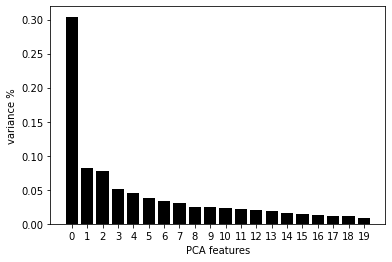

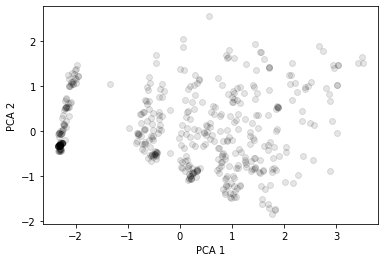

In [35]:
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(input_df.drop(columns=['email', 'first', 'last', 'sid']).to_numpy())
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
plt.show()

PCA_components = pd.DataFrame(principalComponents)


plt.scatter(PCA_components[0], PCA_components[1], alpha=.1, color='black')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()




## Deep nn reward model (Q-net)

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [46]:
input_w_groups = input_df.merge(group_stud_rew[['sid', 'group_num', 'group_score']], on=['sid'])
input_w_groups.columns

Index(['email', 'first', 'last', 'sid', 'id_importance', 'race_importance',
       'courses_completed_61A',
       'courses_completed_61A, Linear Algebra course at a community college',
       'courses_completed_61A, Math 54 (Note Math 54 is not required at all for the L&S or EECS major and is not required for 16A)',
       'courses_completed_Linear Algebra course at a community college',
       ...
       'experience_I have not had much exposure to programming',
       'experience_I have not had much exposure to programming, I have had lots of exposure to linear algebra',
       'experience_I have not had much exposure to programming, I have had some exposure to linear algebra',
       'experience_I have not had much exposure to programming, I have had some exposure to programming',
       'experience_I have not had much exposure to programming, I have not had much exposure to linear algebra',
       'hist_underrepresented_Maybe', 'hist_underrepresented_No',
       'hist_underrepresen

In [84]:
X = input_w_groups.drop(columns=['email', 'first', 'last']).rename(columns={'sid':'student_id'})
X['group_score'] = X['group_score']/np.max(X['group_score'])
X = X.to_csv("ipynb/16a_fa20_data/cleaned/ML_inputdf.csv")
# X = X.drop(columns=['student_id'])

In [68]:
## Fixed parameters
D_in = X.shape[1]-2  # Don't include group information in input to network, but batch=1 group
D_out = 1
D_in

128

In [69]:
## Hyperparameters
lrs = [1e-5, 5e-5, 1e-4, 2.5e-4, 5e-4, 1e-3, 5e-3]
t_iters = [100, 500, 1000, 2000, 5000, 10000]
# batch_size = [5, 10, 20]

hidden_layers = 2
layer_size = 128
max_per_group = group_scores['count'].max()

In [74]:
def run_nn(lr, t_iters, hidden_layers, layer_size, split_idxs, return_model=False):
    ### Set up Q-net
    q_net = torch.nn.Sequential(
        torch.nn.Linear(D_in*max_per_group, layer_size),
        torch.nn.ReLU(),
        torch.nn.Linear(layer_size, layer_size),
        torch.nn.ReLU(),
        torch.nn.Linear(layer_size, D_out),
    )

    loss_fn = torch.nn.MSELoss(reduction='sum')
    params = list(q_net.parameters())
    
    optimizer = torch.optim.Adam(params, lr=lr)
    
    
    #Train/validation split
    split_perc = 0.05
#     print(groups)
    gps_valid = groups.iloc[split_idxs[:int(split_perc*groups.shape[0])]]
    gps_train = groups.iloc[split_idxs[int(split_perc*groups.shape[0]):]]
    
    #Pre-train q-network
    losses = []
    gps_random = gps_train.iloc[np.random.permutation(gps_train.shape[0])]
    for t in range(t_iters):
        gp = gps_random.iloc[t%gps_train.shape[0]]
#         print(gp)
        group_num = gp['group_num']

        if t % gps_train.shape[0] == 0: #Shuffle groups after running through them once
            gps_random = gps_train.iloc[np.random.permutation(gps_train.shape[0])]

        group_pre = X[X['group_num'] == group_num]
        group_ind_scores = group_pre['group_score']
        group_array = group_pre.drop(columns=['group_num','group_score']).to_numpy()
        group_t = np.zeros((D_in*max_per_group, 1))
#         print(t)
#         print(D_in)
#         print(group_array.shape[1])
#         print(group_t.shape)
#         print(group_array.shape[0])
#         print()
        for i in range(group_array.shape[0]):
#             print(group_array[i].shape)
            group_t[i*D_in:(i+1)*D_in] = group_array[i].reshape(D_in,1)
        
        
        y_pred = q_net(torch.tensor(group_t.T).float())
        y_final_pred = torch.mean(y_pred)

        y_true = torch.tensor(gp['group_score']).float()

        loss = loss_fn(y_final_pred, y_true)
        if t % (t_iters//10) == (t_iters//10 - 1):
#             print(t, loss.item())
            losses.append([loss.item()])

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()

        loss.backward()

        # Update the weights using Adam
        optimizer.step()
        
    #Validation loss
    valid_losses = []
    for i in range(gps_valid.shape[0]):
        gp = gps_valid.iloc[i]
        group_num = gp['group_num']
        
        
        group_pre = X[X['group_num'] == group_num]
        group_ind_scores = group_pre['group_score']
        group_array = group_pre.drop(columns=['group_num','group_score']).to_numpy()
        group_t = np.zeros((D_in*max_per_group, 1))
        
        
#         print(group_array.shape[0])
        for i in range(group_array.shape[0]):
#             print(group_array[i].shape)
            group_t[i*D_in:(i+1)*D_in] = group_array[i].reshape(D_in,1)
            
#         group_t = X[X['group_num'] == group_num].drop(columns=['group_num','group_score']).to_numpy()
        y_pred = q_net(torch.tensor(group_t.T).float())
        y_final_pred = torch.mean(y_pred)

        y_true = torch.tensor(gp['group_score']).float()

        loss = loss_fn(y_final_pred, y_true)
        
        valid_losses.append([loss.item()])
    if return_model:
        return np.array(losses).squeeze(), np.mean(np.array(valid_losses)), q_net
    else:
        del q_net
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        return np.array(losses).squeeze(), np.mean(np.array(valid_losses)), None

In [80]:
split_idxs = np.random.permutation(groups.shape[0])

# train_losses = np.zeros((len(lrs), len(t_iters), 10))
# valid_losses = np.zeros((len(lrs), len(t_iters)))
# best_valid_loss = 500
# best_model = None
# for i1 in range(len(lrs)):
#     for i2 in range(len(t_iters)):
#         print("\nNew training cycle")
#         print("learning rate: ", lrs[i1])
#         print("training iterations:", t_iters[i2])
#         res = run_nn(lrs[i1], t_iters[i2], hidden_layers, layer_size, split_idxs)
#         print(res[1])
#         train_losses[i1, i2], valid_losses[i1, i2], model = res
#         if valid_losses[i1, i2] < best_valid_loss:
#             best_valid_loss = valid_losses[i1, i2]
#             best_model = model
            
res = run_nn(0.01, 20000, hidden_layers, layer_size, split_idxs)
# train_losses[i1, i2], valid_losses[i1, i2], model = res
# if valid_losses[i1, i2] < best_valid_loss:
#     best_valid_loss = valid_losses[i1, i2]
#     best_model = model
res

(array([2.24803209e+00, 3.41233820e-01, 4.94595349e-01, 1.92010880e-01,
        3.12233686e+00, 1.76254828e-02, 1.28252641e-03, 1.58308327e+00,
        1.84568930e-02, 2.37181429e-02]),
 1.15599545960625,
 None)

In [72]:
print(valid_losses)
print(np.min(valid_losses))
##Change this to separate whole groups out for training and evaluation,
##  rather than students
idxs = np.unravel_index(np.argmin(valid_losses, axis=None), valid_losses.shape)
print("Best eval performance: learning rate", lrs[idxs[0]],  ", training iterations:",t_iters[idxs[1]])

[[10.73421165 11.82642694  9.51406747  8.46641566  8.49149076  9.10791749]
 [ 7.94661759  6.7750001   6.11620508  7.2392578   6.81509302  8.19326869]
 [ 6.30535449  7.95649364  8.35032859  8.40269125  8.2001605   9.22637198]
 [ 5.91094624  5.24123231  5.87737959  7.6786539   6.12617563  4.74595902]
 [ 7.70513346  7.86562248  7.15731155  9.53336923 10.57945976  4.96780215]]
4.74595901795796
Best eval performance: learning rate 0.01 , training iterations: 20000


In [73]:
import seaborn as sns

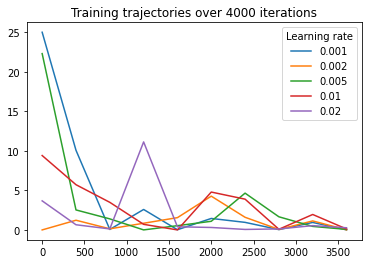

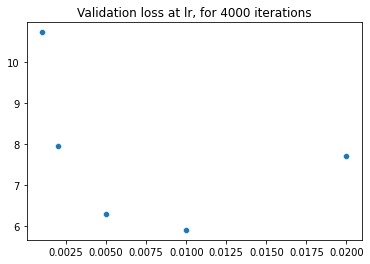

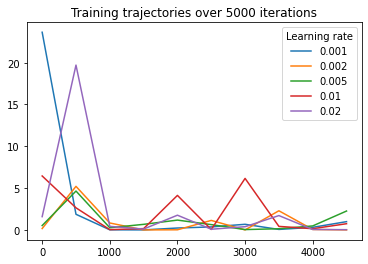

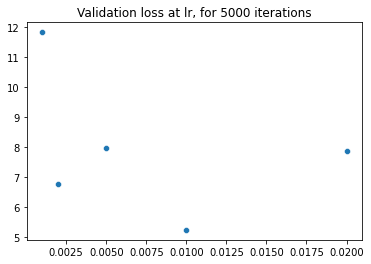

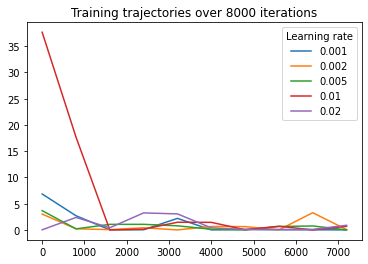

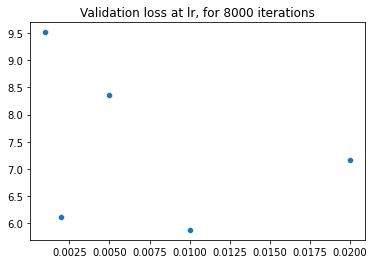

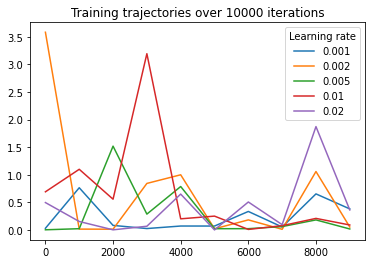

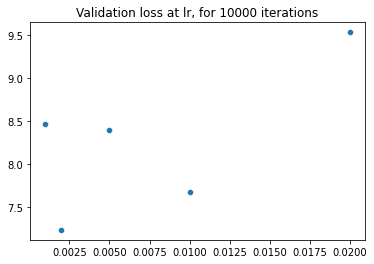

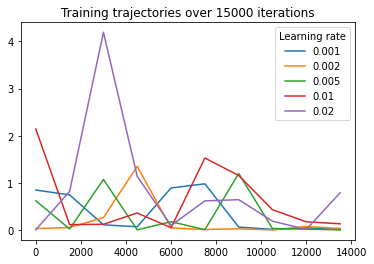

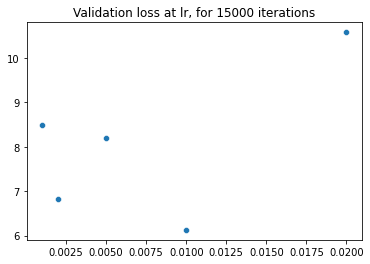

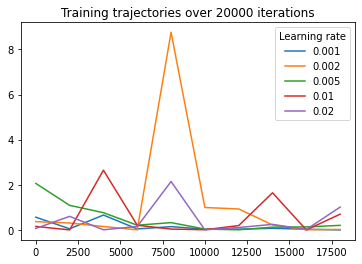

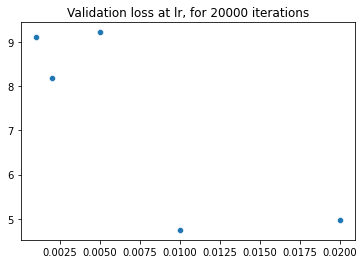

In [74]:
# valid_pivot = pd.pivot_table(values=train_losses, index=t_iters, columns=lrs)
# sns.scatterplot(data=valid_pivot)
for i2 in range(len(t_iters)):
    for i1 in range(len(lrs)):
        train_trajectory = train_losses[i1, i2]
        sns.lineplot(x = np.round(np.arange(10)/10*t_iters[i2]), 
                     y = train_trajectory)
    plt.title("Training trajectories over " + str(t_iters[i2]) + " iterations")
    plt.legend(labels=lrs, title="Learning rate")
    plt.show()
    
    sns.scatterplot(y = valid_losses[:,i2], x=lrs)
    plt.title("Validation loss at lr, for " + str(t_iters[i2]) +" iterations")
    plt.show()


In [76]:
# lrs = [1e-3, 2e-3, 5e-3, 1e-2, 2e-2]
# t_iters = [4000, 5000, 8000, 10000, 15000, 20000]

# split_idxs = np.random.permutation(groups.shape[0])

# train_losses = np.zeros((len(lrs), len(t_iters), 10))
# valid_losses = np.zeros((len(lrs), len(t_iters)))
# # best_valid_loss = 500

# for i1 in range(len(lrs)):
#     for i2 in range(len(t_iters)):
#         print("\nNew training cycle")
#         print("learning rate: ", lrs[i1])
#         print("training iterations:", t_iters[i2])
#         train_losses[i1, i2], valid_losses[i1, i2], model = run_nn(lrs[i1], t_iters[i2], hidden_layers, layer_size, split_idxs)
#         if valid_losses[i1, i2] < best_valid_loss:
#             best_valid_loss = valid_losses[i1, i2]
#             best_model = model

In [3]:
import matplotlib.pyplot as plt

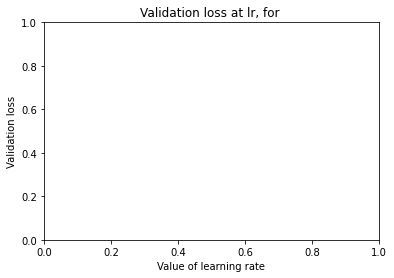

In [10]:
# for i2 in range(len(t_iters)):
#     for i1 in range(len(lrs)):
#         train_trajectory = train_losses[i1, i2]
#         sns.lineplot(x = np.round(np.arange(10)/10*t_iters[i2]), 
#                      y = train_trajectory)
#     plt.title("Training trajectories over " + str(t_iters[i2]) + " iterations")
#     plt.legend(labels=lrs, title="Learning rate")
#     plt.show()
    
#     sns.scatterplot(y = valid_losses[:,i2], x=lrs)
#     plt.title("Validation loss at lr, for " + str(t_iters[i2]) +" iterations")
#     plt.xlabel()
#     plt.show()

# sns.scatterplot(y = valid_losses[:,i2], x=lrs)
plt.title("Validation loss at lr, for ")
plt.xlabel("Value of learning rate")
plt.ylabel("Validation loss")
plt.show()

In [ ]:

idxs = np.unravel_index(np.argmin(valid_losses, axis=None), valid_losses.shape)
print("Best eval performance: learning rate", lrs[idxs[0]],  ", training iterations:",t_iters[idxs[1]])
print(np.min(valid_losses,axis=None))

### Best model

In [67]:
split_idxs = np.random.permutation(groups.shape[0])

train_loss, valid_loss, q_net = run_nn(0.002, 20000, hidden_layers, layer_size, split_idxs, return_model=True)
valid_loss

1999 0.009646955877542496
3999 0.07775816321372986
5999 0.8595005869865417
7999 0.42924392223358154
9999 0.10796286910772324
11999 0.07207860052585602
13999 0.028184033930301666
15999 0.006286927964538336
17999 0.3347834050655365
19999 0.02701297029852867


4.39617184656007

In [70]:
layer1_weights = q_net[0].weight.detach().numpy()
